In [1]:
from NPHM.models.deepSDF import DeepSDF, DeformationNetwork
from NPHM.models.EnsembledDeepSDF import FastEnsembleDeepSDFMirrored
from NPHM import env_paths

import numpy as np
import json, yaml
import os
import os.path as osp
import torch
import matplotlib.pyplot as plt

In [2]:
# load general config
with open('NPHM-main/scripts/configs/fitting_nphm.yaml', 'r') as f:
    print('Loading config file from: ' + 'scripts/configs/fitting_nphm.yaml')
    CFG = yaml.safe_load(f)
print(json.dumps(CFG, sort_keys=True, indent=4))

# paths to shape and expression MLP config
weight_dir_shape = env_paths.EXPERIMENT_DIR + '/{}/'.format(CFG['exp_name_shape'])
weight_dir_expr = env_paths.EXPERIMENT_DIR + '/{}/'.format(CFG['exp_name_expr'])

# load shape and expression MLP config
fname_shape = weight_dir_shape + 'configs.yaml'
with open(fname_shape, 'r') as f:
    print('Loading config file from: ' + fname_shape)
    CFG_shape = yaml.safe_load(f)
fname_expr = weight_dir_expr + 'configs.yaml'
with open(fname_expr, 'r') as f:
    print('Loading config file from: ' + fname_expr)
    CFG_expr = yaml.safe_load(f)

device = torch.device("cpu")

# Load anchor points
lm_inds = np.load(env_paths.ANCHOR_INDICES_PATH)
anchors = torch.from_numpy(np.load(env_paths.ANCHOR_MEAN_PATH)).float().unsqueeze(0).unsqueeze(0).to(device)

# Initialize Shape MLP using CFG
decoder_shape = FastEnsembleDeepSDFMirrored(
        lat_dim_glob=CFG_shape['decoder']['decoder_lat_dim_glob'],
        lat_dim_loc=CFG_shape['decoder']['decoder_lat_dim_loc'],
        hidden_dim=CFG_shape['decoder']['decoder_hidden_dim'],
        n_loc=CFG_shape['decoder']['decoder_nloc'],
        n_symm_pairs=CFG_shape['decoder']['decoder_nsymm_pairs'],
        anchors=anchors,
        n_layers=CFG_shape['decoder']['decoder_nlayers'],
        pos_mlp_dim=CFG_shape['decoder'].get('pos_mlp_dim', 256),
    )

decoder_shape = decoder_shape.to(device)

# Initialize Expression MLP using CFG
decoder_expr = DeformationNetwork(mode=CFG_expr['ex_decoder']['mode'],
                                 lat_dim_expr=CFG_expr['ex_decoder']['decoder_lat_dim_expr'],
                                 lat_dim_id=CFG_expr['ex_decoder']['decoder_lat_dim_id'],
                                 lat_dim_glob_shape=CFG_expr['id_decoder']['decoder_lat_dim_glob'],
                                 lat_dim_loc_shape=CFG_expr['id_decoder']['decoder_lat_dim_loc'],
                                 n_loc=CFG_expr['id_decoder']['decoder_nloc'],
                                 anchors=anchors,
                                 hidden_dim=CFG_expr['ex_decoder']['decoder_hidden_dim'],
                                 nlayers=CFG_expr['ex_decoder']['decoder_nlayers'],
                                 input_dim=3, out_dim=3
                                 )

decoder_expr = decoder_expr.to(device)

# Load shape MLP weights
path = osp.join(weight_dir_shape, 'checkpoints/checkpoint_epoch_{}.tar'.format(CFG['checkpoint_shape']))
print('Loaded checkpoint from: {}'.format(path))
checkpoint = torch.load(path, map_location=device)
decoder_shape.load_state_dict(checkpoint['decoder_state_dict'], strict=True)

if 'latent_codes_state_dict' in checkpoint:
    n_train_subjects = checkpoint['latent_codes_state_dict']['weight'].shape[0]
    n_val_subjects = checkpoint['latent_codes_val_state_dict']['weight'].shape[0]
    latent_codes_shape = torch.nn.Embedding(n_train_subjects, 512)
    latent_codes_shape_val = torch.nn.Embedding(n_val_subjects, 512)
    
    latent_codes_shape.load_state_dict(checkpoint['latent_codes_state_dict'])
    latent_codes_shape_val.load_state_dict(checkpoint['latent_codes_val_state_dict'])
else:
    print('no latent codes in state dict of shape decoder')
    latent_codes_shape = None
    latent_codes_shape_val = None

# Load expression MLP weights
path = osp.join(weight_dir_expr, 'checkpoints/checkpoint_epoch_{}.tar'.format(CFG['checkpoint_expr']))
print('Loaded checkpoint from: {}'.format(path))
checkpoint = torch.load(path, map_location=device)
decoder_expr.load_state_dict(checkpoint['decoder_state_dict'], strict=True)
if 'latent_codes_state_dict' in checkpoint:
    latent_codes_expr = torch.nn.Embedding(checkpoint['latent_codes_state_dict']['weight'].shape[0], 200)
    latent_codes_expr.load_state_dict(checkpoint['latent_codes_state_dict'])
    latent_codes_expr_val = torch.nn.Embedding(checkpoint['latent_codes_val_state_dict']['weight'].shape[0], 200)
    latent_codes_expr_val.load_state_dict(checkpoint['latent_codes_val_state_dict'])
else:
    print('no latent codes in state dict of exression decoder')
    latent_codes_expr = None
    latent_codes_expr_val = None

Loading config file from: scripts/configs/fitting_nphm.yaml
{
    "checkpoint_expr": 2500,
    "checkpoint_shape": 15000,
    "exp_name_expr": "nphm_expression_space_pretrained",
    "exp_name_shape": "nphm_identity_space_pretrained",
    "lambdas_shape": {
        "reg_global": 0.002,
        "reg_unobserved": "5.0 0",
        "reg_zero": 0.005,
        "surface": 2.0,
        "symm_dist": 1.0
    },
    "local_expr": false,
    "local_shape": true,
    "mode": "compress"
}
Loading config file from: /Users/katharinaschmid/Text2Head/NPHM-main/weights//nphm_identity_space_pretrained/configs.yaml
Loading config file from: /Users/katharinaschmid/Text2Head/NPHM-main/weights//nphm_expression_space_pretrained/configs.yaml
creating DeepSDF with...
lat dim 232
hidden_dim 512
235
512
Loaded checkpoint from: /Users/katharinaschmid/Text2Head/NPHM-main/weights//nphm_identity_space_pretrained/checkpoints/checkpoint_epoch_15000.tar
no latent codes in state dict of shape decoder
Loaded checkpoint fro

In [63]:
lat_mean = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_mean.npy')) # [1344]
lat_rep_id = lat_mean

def phong_model(sdf, points, normals, camera_position, phong_params, light_params, mesh_path, index_tri=None):
    
    if normals == None:
        # Option 1: Use SDF
        normals = estimate_normals(sdf, points)
        # Option 2: Use Mesh
        #normals = mesh_normals(mesh_path, index_tri)
        
    view_dirs = points - camera_position 
    light_dir_1 = light_params["light_dir_1"].repeat(points.shape[0], 1) 
    light_dir_2 = light_params["light_dir_2"].repeat(points.shape[0], 1)
    light_dir_3 = light_params["light_dir_3"].repeat(points.shape[0], 1)
    
    # Normalize all vectors
    normals = (normals.T / torch.norm(normals, dim=-1)).T
    light_dir_norm_1 = (light_dir_1.T / torch.norm(light_dir_1, dim=-1)).T
    light_dir_norm_2 = (light_dir_2.T / torch.norm(light_dir_2, dim=-1)).T
    light_dir_norm_3 = (light_dir_3.T / torch.norm(light_dir_3, dim=-1)).T
    view_dir_norm = (view_dirs.T / torch.norm(view_dirs, dim=-1)).T
    
    # Ambient
    ambient = phong_params["ambient_coeff"] * light_params["amb_light_color"] 
    ambient_refl = ambient.repeat(points.shape[0], 1)
    
    # Area light 1
    diffuse_1 = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0) * light_params["light_intensity_1"] # [N]
    diffuse_refl_1 = torch.matmul(diffuse_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    reflect_dir_1 = light_dir_norm_1 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0)).T
    specular_1 = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_1 * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_1"] # [N]
    specular_refl_1 = torch.matmul(specular_1.unsqueeze(1), light_params["light_color_1"].unsqueeze(0)) # [N, 3]
    
    # Area light 2
    diffuse_2 = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_2 * normals, dim=-1), min=0.0) * light_params["light_intensity_2"] # [N]
    diffuse_refl_2 = torch.matmul(diffuse_2.unsqueeze(1), light_params["light_color_2"].unsqueeze(0)) # [N, 3]
    reflect_dir_2 = light_dir_norm_2 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_2 * normals, dim=-1), min=0.0)).T
    specular_2 = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_2 * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_2"] # [N]
    specular_refl_2 = torch.matmul(specular_2.unsqueeze(1), light_params["light_color_2"].unsqueeze(0)) # [N, 3]
    
    # Area light 3
    diffuse_3 = phong_params["diffuse_coeff"] * torch.clamp(torch.sum(-light_dir_norm_3 * normals, dim=-1), min=0.0) * light_params["light_intensity_3"] # [N]
    diffuse_refl_3 = torch.matmul(diffuse_3.unsqueeze(1), light_params["light_color_3"].unsqueeze(0)) # [N, 3]
    reflect_dir_3 = light_dir_norm_3 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_3 * normals, dim=-1), min=0.0)).T
    specular_3 = phong_params["specular_coeff"] * torch.pow(torch.clamp(torch.sum(reflect_dir_3 * -view_dir_norm, dim=-1), min=0.0), phong_params["shininess"]) * light_params["light_intensity_3"] # [N]
    specular_refl_3 = torch.matmul(specular_3.unsqueeze(1), light_params["light_color_3"].unsqueeze(0)) # [N, 3]
    
    # point light
    #diffuse_1 = diffuse_coeff * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0) * light_intensity_1 # [N]
    #diffuse_refl_1 = torch.matmul(diffuse_1.unsqueeze(1), light_color.unsqueeze(0)) # [N, 3]
    #reflect_dir_1 = light_dir_norm_1 + (2 * normals.T * torch.clamp(torch.sum(-light_dir_norm_1 * normals, dim=-1), min=0.0)).T
    #specular_1 = specular_coeff * torch.pow(torch.clamp(torch.sum(reflect_dir_1 * -view_dir_norm, dim=-1), min=0.0), shininess) * light_intensity_1 # [N]
    #specular_refl_1 = torch.matmul(specular_1.unsqueeze(1), light_color.unsqueeze(0)) # [N, 3]

    return ambient_refl + diffuse_refl_1 + specular_refl_1 + diffuse_refl_2 + specular_refl_2 + diffuse_refl_3 + specular_refl_3

def estimate_normals(sdf, points, epsilon=1e-3):
    sdf_inputs = torch.concat([points,
                              points + torch.tensor([epsilon, 0, 0]),
                              points + torch.tensor([0, epsilon, 0]),
                              points + torch.tensor([0, 0, epsilon])])

    sdf_values = sdf(sdf_inputs).reshape(4, -1)

    # Calculate the gradient using finite differences
    gradient = sdf_values[1:] - sdf_values[0]

    # Normalize the gradient to obtain the estimated normal
    normal = gradient / torch.norm(gradient, p=2, dim=0)

    return normal.T

def sphere_trace(sdf, camera_position, norm_directions, max_length):
    N = norm_directions.shape[0]
    positions = camera_position.unsqueeze(dim=0).repeat(N, 1) # [N, 3]
    total_distances = torch.zeros(N)
    last_distances = torch.ones(N)

    for _ in range(20):
        #mask = torch.logical_and(total_distances < max_length, last_distances > 1e-3)
        not_reached_max_distance = total_distances < max_length
        not_hit_target = torch.abs(last_distances) > 1e-3
        mask = torch.logical_and(not_reached_max_distance, not_hit_target)
        if torch.all(torch.logical_not(mask)):
            break
        distances = sdf(positions[mask])
        steps = (norm_directions[mask].T * distances).T
        positions[mask] += steps
        total_distances[mask] += distances
        last_distances[mask] = distances

    #positions[total_distances > max_length] *= torch.nan
    return positions, total_distances < max_length

'''
def mesh_trace(mesh_path, ray_starts, ray_directions):
    mesh = trimesh.load_mesh(mesh_path)
    
    ray_origins = ray_starts.repeat(ray_directions.shape[0], 1)
    
    intersections, index_ray, index_tri = mesh.ray.intersects_location(ray_origins, ray_directions, multiple_hits=False) 
    
    mask = torch.zeros(ray_directions.shape[0], dtype=torch.bool)
    mask[index_ray] = True
    
    points = torch.as_tensor(intersections, dtype=torch.float32)

    return points, mask, index_tri


def mesh_normals(mesh_path, index_tri):
    mesh = trimesh.load_mesh(mesh_path)
    all_normals = mesh.face_normals
    normals = all_normals[index_tri]
    normals_torch = torch.from_numpy(normals).to(dtype=torch.float32)
    
    return normals_torch
'''
def render(model, lat_rep, camera_params, phong_params, light_params, mesh_path=None):
    
    def sdf(positions):
        nphm_input = torch.reshape(positions, (1, -1, 3))
        distance, _ = model(nphm_input, torch.reshape(lat_rep, (1, 1, -1)), None)
        return distance.squeeze()

    pu = camera_params["resolution_x"]
    pv = camera_params["resolution_y"]
    image = phong_params["background_color"].repeat(pu * pv, 1)
    
    angle_radians = torch.deg2rad_(torch.tensor(camera_params["camera_angle"]))
    camera = torch.tensor([torch.sin(angle_radians), 0, torch.cos(angle_radians)])
    camera_position = camera * (camera_params["camera_distance"] + camera_params["focal_length"]) / camera.norm()
    
    # Normalize the xy value of the current pixel [-0.5, 0.5]
    u_norms = ((torch.arange(pu) + 0.5) / pu - 0.5) * pu/pv
    v_norms = 0.5 - (torch.arange(pv) + 0.5) / pv

    # Calculate the ray directions for all pixels
    directions_unn = torch.cat(torch.meshgrid(u_norms, v_norms, torch.tensor(-camera_params["focal_length"]), indexing='ij'), dim=-1) 
    directions_unn = directions_unn.reshape((pu*pv, 3)) # [pu, pv, 3] --> [pu*pv, 3] (u1, v1, f)(u1, v2, f)...(u2, v1, f)...

    # rotate about y-axis
    rotation_matrix = torch.tensor([[torch.cos(angle_radians), 0, torch.sin(angle_radians)],
                                    [0, 1, 0],
                                    [-torch.sin(angle_radians), 0, torch.cos(angle_radians)]])
    rotated_directions = torch.matmul(directions_unn, rotation_matrix.T)
    
    transposed_directions = rotated_directions.T #transpose is necessary for normalization
    directions = (transposed_directions / transposed_directions.norm(dim=0)).T # [pu*pv, 3]

    # Option 1: Use SDF
    hit_positions, hit_mask = sphere_trace(sdf, camera_position, directions, camera_params['max_ray_length'])
    # Option 2: Use Mesh
    #intersections, hit_mask, index_tri = mesh_trace(mesh_path, camera_position, directions) 
    
    # Option 1: Use SDF
    normals = None
    reflections = phong_model(sdf, hit_positions[hit_mask], normals, camera_position, phong_params, light_params, mesh_path)
    # Option 2: Use Mesh
    #reflections = phong_model(sdf, intersections, camera_position, phong_params, light_params, mesh_path, index_tri) # mesh alternative

    # Assign a color for objects
    image[hit_mask] = torch.mul(reflections, phong_params["object_color"].repeat(reflections.shape[0], 1))
    image = torch.clamp(image, max=1.0)
    image = image.reshape(pu, pv, 3).transpose(0, 1)


    return image

camera_params = {
    "camera_distance": 0.4, #3.11, # [2, 6] distance of camera to origin
    "camera_angle": 20., # [-90, 90] angle between z-axis and camera axis
    "focal_length": 2.,#6., # [2., 9.]
    "max_ray_length": 3.11 + 6 + 1.5,
    # Image
    "resolution_y": 120,
    "resolution_x": 120
}

phong_params = {
    "ambient_coeff": 0.5,
    "diffuse_coeff": 0.7,
    "specular_coeff": 0.0,
    "shininess": 3.0,
    # Colors
    "object_color": torch.tensor([0.61, 0.61, 0.61]),
    "background_color": torch.tensor([0.46, 0, 0])
}

light_params = {
    "amb_light_color": torch.tensor([0.15, 0, 0]),
    # light 1
    "light_intensity_1": 1., # [0, 1.5]
    "light_color_1": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_1": torch.tensor([-1., -1., -1.]), # [-1, 1]
    # light 2
    "light_intensity_2": 1., # [0, 1.5]
    "light_color_2": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_2": torch.tensor([0., 0., -1.]), # [-1, 1]
    # light 3
    "light_intensity_3": 0., # [0, 1.5]
    "light_color_3": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_3": torch.tensor([0., -1., 0.]) # [-1, 1]
}

#with torch.no_grad():
    #image = render(decoder_shape, lat_rep_id, camera_params, phong_params, light_params)

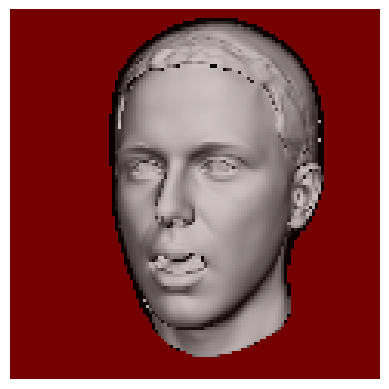

In [7]:
plt.imshow(image.detach().numpy())
plt.axis('off')  # Turn off axes
plt.show()

ok
torch.Size([4900, 3])
torch.Size([2089, 5])
torch.Size([2089])
torch.Size([1069])
tensor([1, 1, 1,  ..., 1, 1, 1])
4
torch.Size([70, 70, 3])


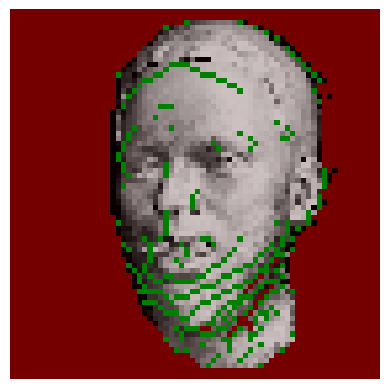

In [73]:
lat_mean = torch.from_numpy(np.load(env_paths.ASSETS + 'nphm_lat_mean.npy')) # [1344]
lat_rep_id = lat_mean
lat_rep_expr = 0.2*torch.randn(CFG_expr['ex_decoder']['decoder_lat_dim_expr']) #[200]

def render_expr(model_id, lat_rep_id, camera_params, phong_params, light_params, mesh_path=None):
    
    def sdf(positions):
        nphm_input = torch.reshape(positions, (1, -1, 3))
        distance, _ = model_id(nphm_input, torch.reshape(lat_rep_id, (1, 1, -1)), None)
        return distance.squeeze()
    print('ok')
    pu = camera_params["resolution_x"]
    pv = camera_params["resolution_y"]
    image = phong_params["background_color"].repeat(pu * pv, 1)
    print(image.shape)
    
    angle_radians = torch.deg2rad_(torch.tensor(camera_params["camera_angle"]))
    camera = torch.tensor([torch.sin(angle_radians), 0, torch.cos(angle_radians)])
    camera_position = camera * (camera_params["camera_distance"] + camera_params["focal_length"]) / camera.norm()
    
    # Normalize the xy value of the current pixel [-0.5, 0.5]
    u_norms = ((torch.arange(pu) + 0.5) / pu - 0.5) * pu/pv
    v_norms = 0.5 - (torch.arange(pv) + 0.5) / pv

    # Calculate the ray directions for all pixels
    directions_unn = torch.cat(torch.meshgrid(u_norms, v_norms, torch.tensor(-camera_params["focal_length"]), indexing='ij'), dim=-1) 
    directions_unn = directions_unn.reshape((pu*pv, 3)) # [pu, pv, 3] --> [pu*pv, 3] (u1, v1, f)(u1, v2, f)...(u2, v1, f)...

    # rotate about y-axis
    rotation_matrix = torch.tensor([[torch.cos(angle_radians), 0, torch.sin(angle_radians)],
                                    [0, 1, 0],
                                    [-torch.sin(angle_radians), 0, torch.cos(angle_radians)]])
    rotated_directions = torch.matmul(directions_unn, rotation_matrix.T)
    
    transposed_directions = rotated_directions.T #transpose is necessary for normalization
    directions = (transposed_directions / transposed_directions.norm(dim=0)).T # [pu*pv, 3]

    # get surface points in identity space
    hit_positions, hit_mask = sphere_trace(sdf, camera_position, directions, camera_params['max_ray_length'])
    x_c = hit_positions[hit_mask] # [N, 3]
    
    # get normals of surface points in identity space
    normals_c = estimate_normals(sdf, x_c)
    # get points to simulate normals
    epsilon = 3e-3
    n_c = x_c + epsilon * normals_c
    points_c = torch.cat((x_c, n_c), dim=0).unsqueeze(0) # [B, 2N, 3]

    # map surface points to expression space
    glob_cond = torch.cat([lat_rep_id, lat_rep_expr], dim=-1) # [dim_id + dim_expr]
    glob_cond = glob_cond.repeat(1, points_c.shape[1], 1) # [B, N, D]
    delta, _ = decoder_expr(points_c, glob_cond, anchors.repeat(1, points_c.shape[1], 1, 1))
    points_p = points_c + delta.squeeze() # [B, 2N, 3]
    
    # transform points from global to camera coord. system
    points_p_camera = torch.matmul(points_p, rotation_matrix) - torch.tensor([0, 0, (camera_params['camera_distance'] + camera_params['focal_length'])]).unsqueeze(0) # [B, N, 3]
    points_p_camera = points_p_camera.squeeze(0) # [2N, 3]
    points_p_camera = points_p_camera.reshape(2, -1, 3)
    x_p_camera = points_p_camera[0, :, :] # [N, 3]
    normals_camera = points_p_camera[1, :, :] - points_p_camera[0, :, :] # [N, 3]

    # perspective projection
    x_image = camera_params['focal_length'] * x_p_camera[:, 0] / x_p_camera[:, 2] 
    y_image = camera_params['focal_length'] * x_p_camera[:, 1] / x_p_camera[:, 2] 
    
    # pure magic: nach meinem Verständnis müsste das genau andersrum sein
    u_indices = torch.floor_divide((1 - (x_image + 0.5)), (1/pu))
    v_indices = torch.floor_divide((y_image + 0.5), (1/pv))
    indices = torch.stack((u_indices, v_indices, x_image, y_image), dim=1) # [N, 4]
    indices = torch.cat((indices, normals_camera), dim=1) # [N, 4+3]
    print(indices.shape)
    # remove indices that are out of bound
    indices_normals_red = indices[(indices[:, 0] < pu) & (indices[:, 1] < pv)] # [N, 2]
    indices_red = indices_normals_red[:, :2] # [N, 2]
    image_coord_red = indices_normals_red[:, 2:4] # [N, 2]
    normals_red = indices_normals_red[:, 4:] # [N, 3]
    
    grid_cell_indices = indices_red[:, 0] * pu + indices_red[:, 1] # [N]
    grid_cell_indices = grid_cell_indices.long()
    print(grid_cell_indices.shape)
    
    # Find Indices of potentially relevant but currently not included grid cells
    min_index = torch.min(grid_cell_indices)
    max_index = torch.max(grid_cell_indices)
    relevant_indices = torch.arange(min_index, max_index)
    missing_indices = relevant_indices[~torch.isin(relevant_indices, grid_cell_indices)].long()
    print(missing_indices.shape)
    
    list = []
    for index in missing_indices:
        # Achtung, Code ist nicht für Randbereiche gemacht --> funktioniert nur, wenn Kopf kleiner als Bild
        # get surrounding indices
        surrounding = torch.tensor([index-pu-1, index-pu, index-pu+1, index-1, index+1, index+pu-1, index+pu, index+pu+1])
        occupied_surrounding = surrounding[torch.isin(surrounding, grid_cell_indices)].long()
        if occupied_surrounding.shape[0] >= 4:
            # Hier nochmal drüber nachdenken
            middle = torch.tensor([index//pv+(1/(2*pu)), index%pv+(1/(2*pv))])
            surrounding_points = image_coord_red[occupied_surrounding, :]
            surrounding_normals = normals_red[occupied_surrounding, :]
    r = torch.tensor(list, dtype=torch.long)
    
    ##
    unique_values, counts = torch.unique(grid_cell_indices, return_counts=True)
    print(counts)
    # Find the index of the maximum count
    max_count_index = torch.argmax(counts)
    occurrences = counts[max_count_index].item()
    print(occurrences)
    ##
    
    reflections = phong_model(sdf, hit_positions[hit_mask], normals_red, camera_position, phong_params, light_params, mesh_path)
    
    image[grid_cell_indices] = torch.mul(reflections, phong_params["object_color"].repeat(reflections.shape[0], 1))
    image[r] = torch.tensor([0, 0.5, 0]).repeat(r.shape[0], 1)
    image = torch.clamp(image, max=1.0)
    image = torch.clamp(image, max=1.0)
    image = image.reshape(pu, pv, 3).transpose(0, 1)
    print(image.shape)
    
    return image

camera_params = {
    "camera_distance": 0.4, #3.11, # [2, 6] distance of camera to origin
    "camera_angle": 20., # [-90, 90] angle between z-axis and camera axis
    "focal_length": 2.,#6., # [2., 9.]
    "max_ray_length": 3.11 + 6 + 1.5,
    # Image
    "resolution_y": 70,
    "resolution_x": 70
}

phong_params = {
    "ambient_coeff": 0.5,
    "diffuse_coeff": 0.7,
    "specular_coeff": 0.0,
    "shininess": 3.0,
    # Colors
    "object_color": torch.tensor([0.61, 0.61, 0.61]),
    "background_color": torch.tensor([0.46, 0, 0])
}

light_params = {
    "amb_light_color": torch.tensor([0.15, 0, 0]),
    # light 1
    "light_intensity_1": 1., # [0, 1.5]
    "light_color_1": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_1": torch.tensor([-1., -1., -1.]), # [-1, 1]
    # light 2
    "light_intensity_2": 1., # [0, 1.5]
    "light_color_2": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_2": torch.tensor([0., 0., -1.]), # [-1, 1]
    # light 3
    "light_intensity_3": 0., # [0, 1.5]
    "light_color_3": torch.tensor([1.0, 1.0, 1.0]), # [0.5, 1]
    "light_dir_3": torch.tensor([0., -1., 0.]) # [-1, 1]
}

with torch.no_grad():
    image = render_expr(decoder_shape, lat_rep_id, camera_params, phong_params, light_params)
    
plt.imshow(image.detach().numpy())
plt.axis('off')  # Turn off axes
plt.show()

In [77]:
a = torch.tensor([[1, 2, 3], [2, 2, 3], [3, 2, 3]])
list = torch.tensor([1, 2])
print(a[list, :])

tensor([[2, 2, 3],
        [3, 2, 3]])
